In [1]:
import time
import math
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

def ad_test(dataset):
    """
    Function use to verify the stationary
    If P-value < 0.05 : data is stationary
    """
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
        
def ad_test_no_print(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    return dftest[1]

In [2]:
# Load the dataset
# ts_data = pd.read_csv('../data/dataHistorian.csv', sep=';', encoding='cp1252')
ts_data = pd.read_csv('../data/it-data-4metrics.csv', sep=',')

# Delete the useless columns
ts_data = ts_data.iloc[:,0:4]
ts_data.head()

,metric_id,timestamp,value,metric_name
0,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157723,13.375,cpu_prct_used
1,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157423,13.500,cpu_prct_used
2,091c334c-a90a-4d8f-ba75-2c936220cd64,1575157123,13.375,cpu_prct_used
3,091c334c-a90a-4d8f-ba75-2c936220cd64,1575156823,13.500,cpu_prct_used
4,091c334c-a90a-4d8f-ba75-2c936220cd64,1575156523,13.750,cpu_prct_used


In [3]:
# Creation of the dictionnary of all the metric_name in association with their metric_id
dic_name = {}
dic_id = {}
for indx in ts_data.index:
    if ts_data['metric_name'][indx] not in dic_name.keys():
        dic_name[ts_data['metric_name'][indx]] = []
    if ts_data['metric_id'][indx] not in dic_name[ts_data['metric_name'][indx]]:
        dic_name[ts_data['metric_name'][indx]].append(ts_data['metric_id'][indx])
        dic_id[ts_data['metric_id'][indx]] = [ts_data['metric_name'][indx]]
keys_name = list(dic_name.keys())
keys_id = list(dic_id.keys())

In [4]:
sample = len(keys_id)
for i in range(sample):
    indx = keys_id[i]
    indexNames = ts_data[ ts_data['metric_id'] == indx ].index
    data = ts_data.iloc[indexNames].sort_values(by='timestamp', ascending=True).loc[:,'value']
    p_value = ad_test_no_print(data)
    if p_value > 0.05:
        data = data.diff().dropna()
    dataset = data.values
    dataset = dataset.astype('float32')
    
    start_order = time.time()
    stepwise_fit = auto_arima(dataset, trace=False, suppress_warnings=True)
    end_order = time.time()
    
    size = int(len(dataset) * 0.67)
    train, valid = dataset[0:size], dataset[size:len(dataset)]
    
    model = ARIMA(train, order=stepwise_fit.order)
    start_train = time.time()
    model_fit = model.fit()
    end_train = time.time()
    
    start_pred = time.time()
    pred = model_fit.predict(1,len(dataset)-len(train))
    end_pred = time.time()
    
    if p_value > 0.05:
        dataset = np.r_[dataset[0], dataset].cumsum()
        pred = np.r_[pred[0], pred].cumsum()
        train = np.r_[pred[0], train].cumsum()
        valid = np.r_[pred[0], valid].cumsum()
    
    testScore = math.sqrt(mean_squared_error(valid, pred))
    dic_id[indx].append(dataset)
    dic_id[indx].append(testScore)
    dic_id[indx].append([train, valid, pred])
    dic_id[indx].append(model_fit.fittedvalues)
    dic_id[indx].append(p_value)
    dic_id[indx].append(end_train - start_train)
    dic_id[indx].append(end_pred - start_pred)
    dic_id[indx].append(end_order - start_order)
    if (i+1) % 28 == 0:
        print("%.2f" % ((100/sample)*(i+1)),"% completed...")

11.07 % completed...
22.13 % completed...
33.20 % completed...
44.27 % completed...
55.34 % completed...
66.40 % completed...
77.47 % completed...
88.54 % completed...
99.60 % completed...


In [5]:
if sample == len(keys_id):
    pd.DataFrame(dic_id).to_csv('ARIMA_bis.csv', encoding='utf-8')

In [6]:
# Here we have two dictionaries:
# First, we have a link between the metric_name and their metric_id

# {'metric_name_1':[metric_id_1, metric_id_2, ...],
#  'metric_name_2':[metric_id_1, metric_id_2, ...],
#  ...}


# Second, we have all the information according to the metric_id

# {'metric_id_1':[metric_name_x, ts_data['value'], RMS, [train, valid, pred], train_pred, p_value, training_time, inference_time, order_time],
#  'metric_id_2':[metric_name_y, ts_data['value'], RMS, [train, valid, pred], train_pred, p_value, training_time, inference_time, order_time],
#  ...}
# 

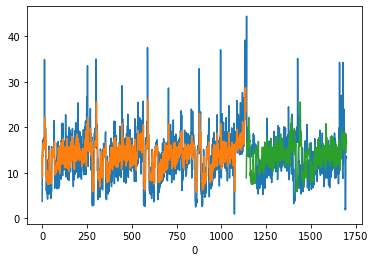

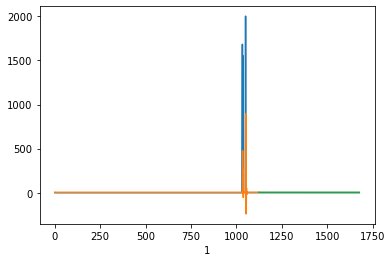

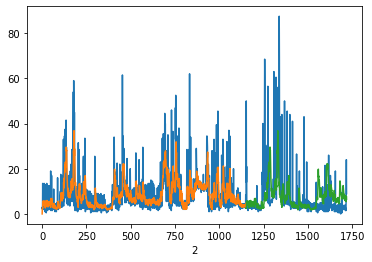

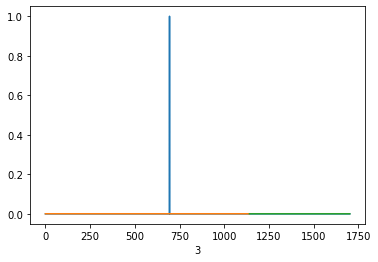

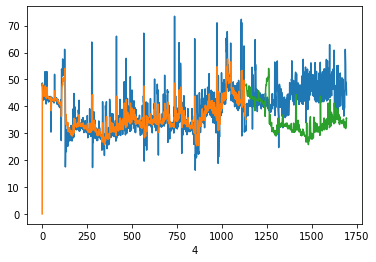

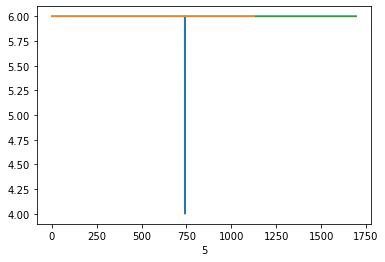

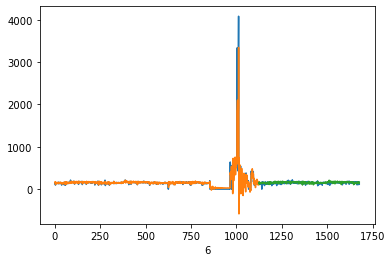

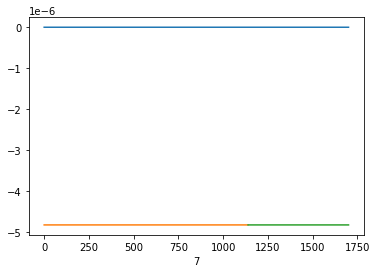

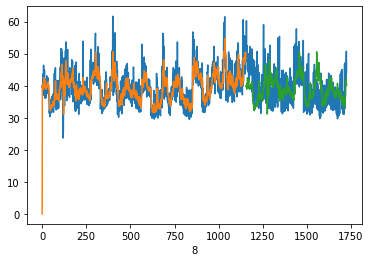

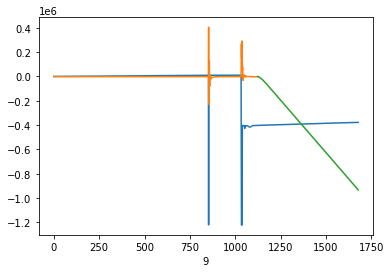

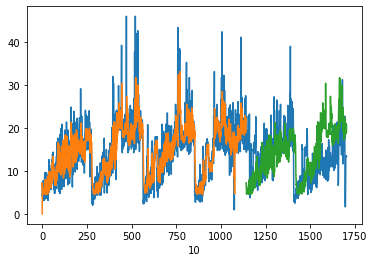

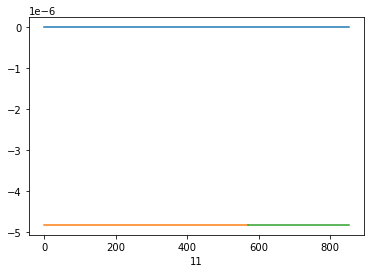

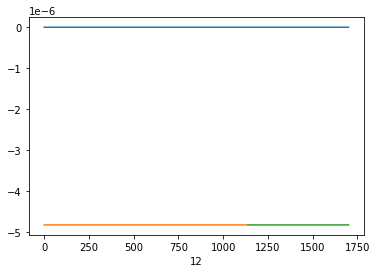

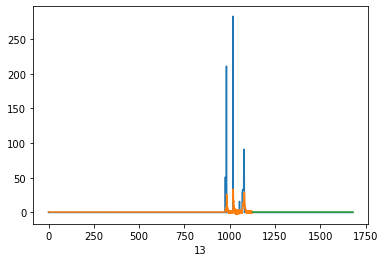

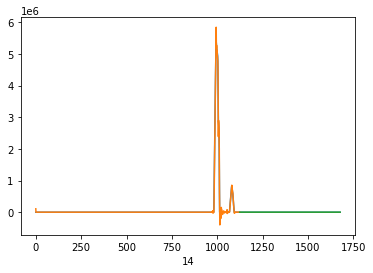

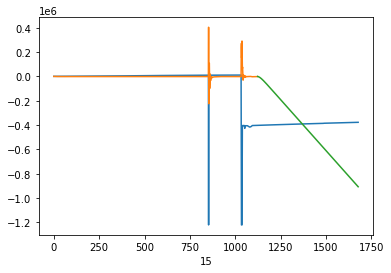

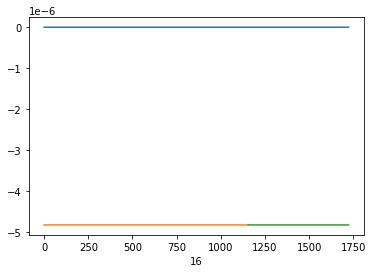

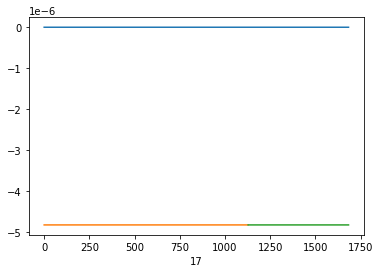

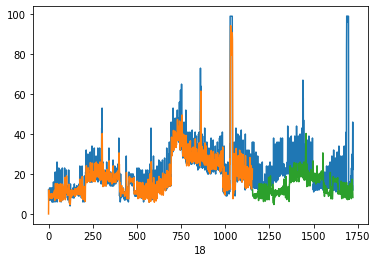

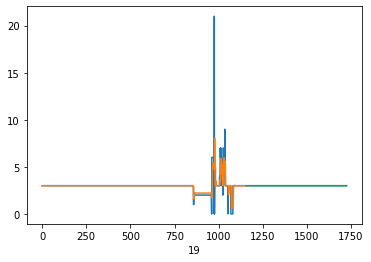

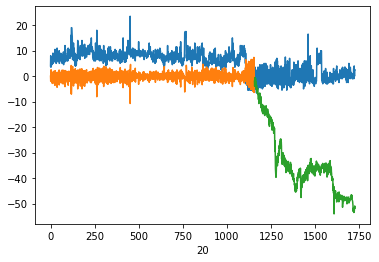

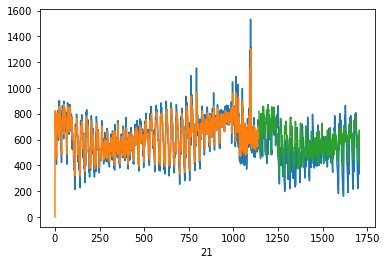

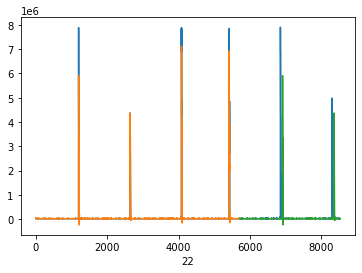

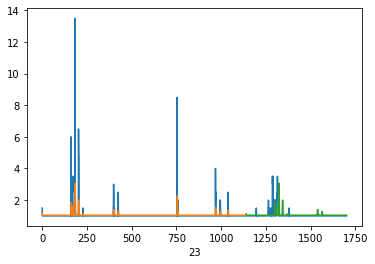

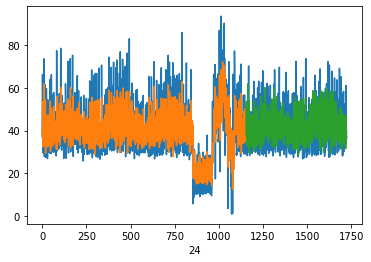

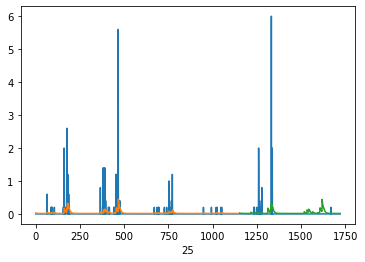

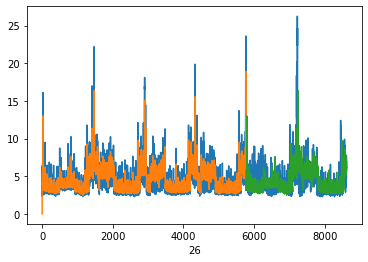

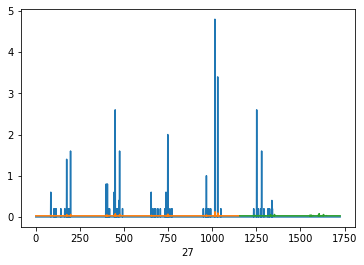

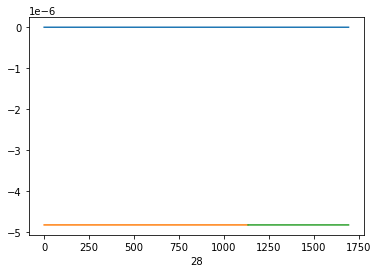

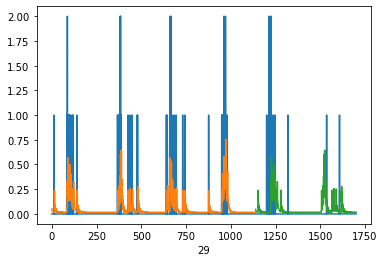

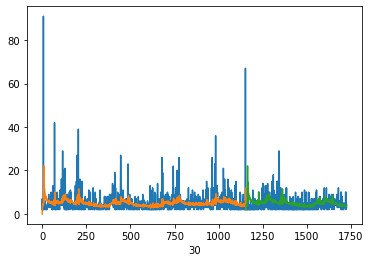

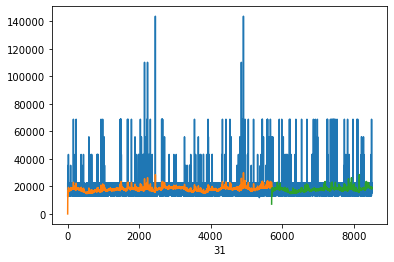

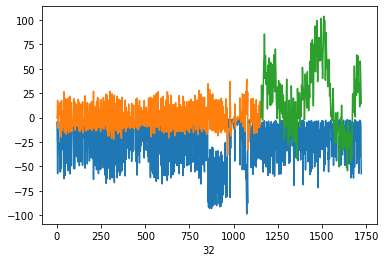

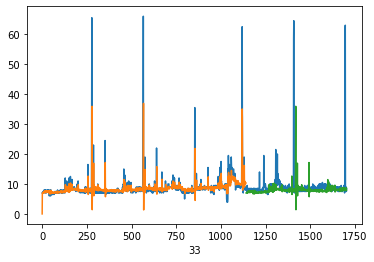

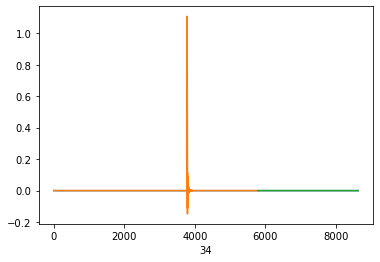

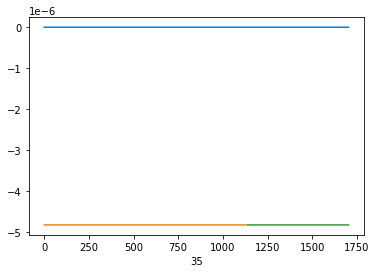

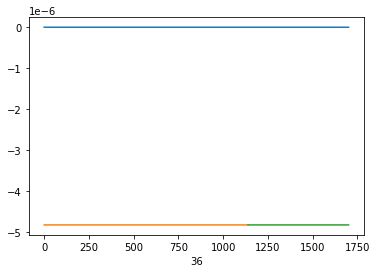

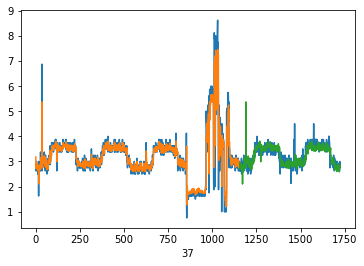

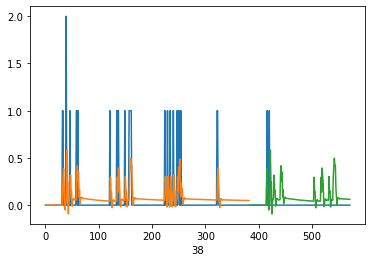

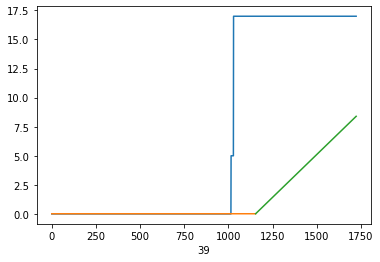

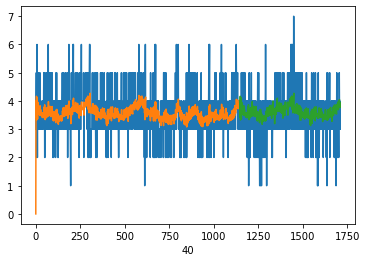

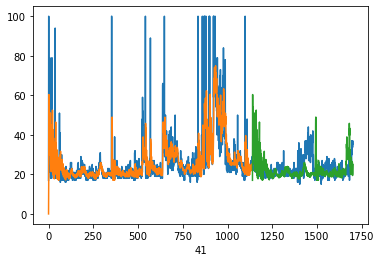

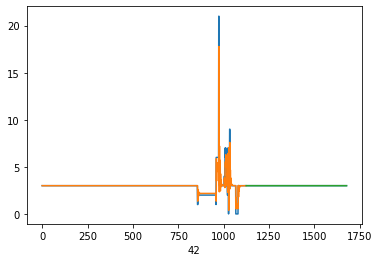

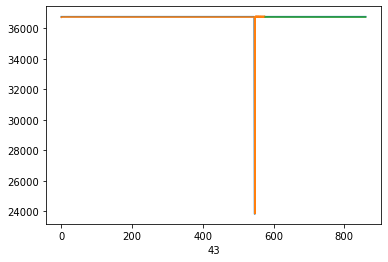

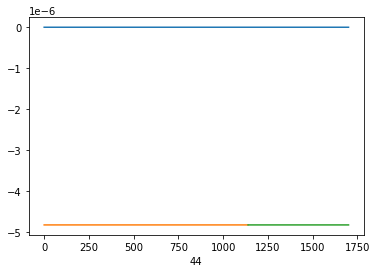

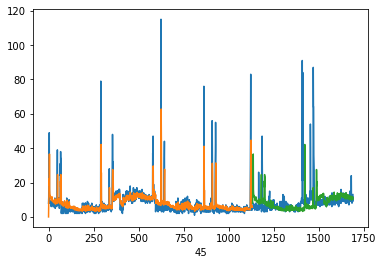

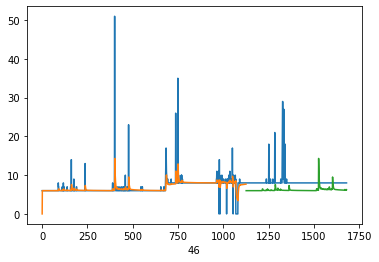

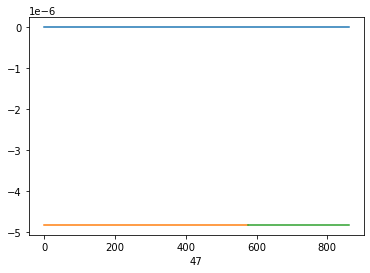

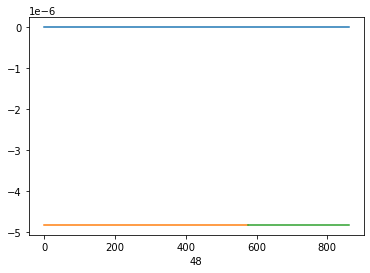

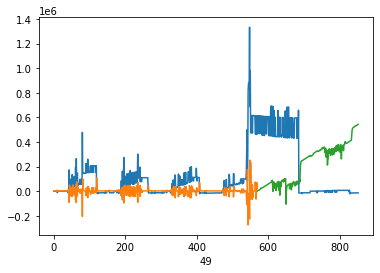

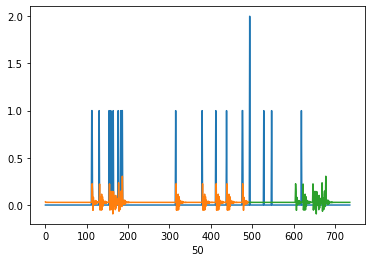

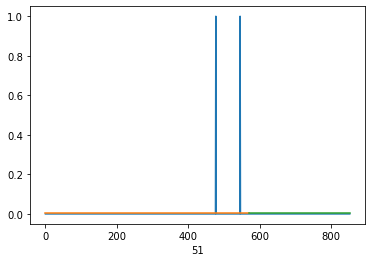

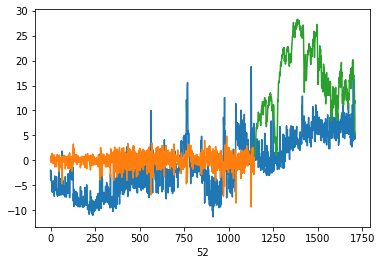

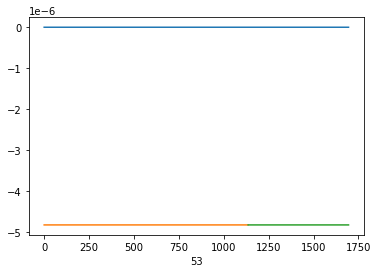

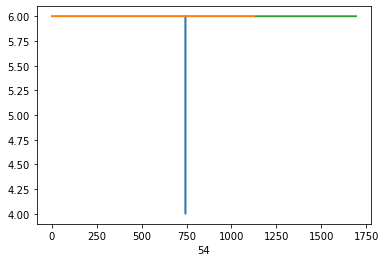

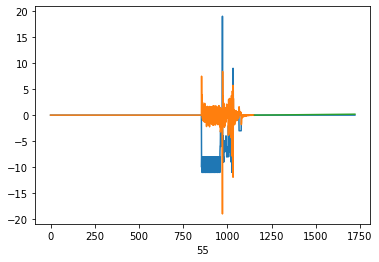

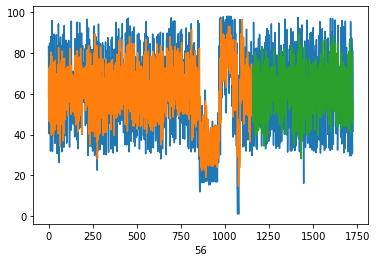

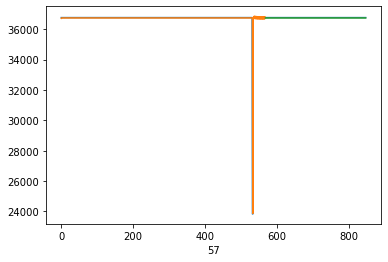

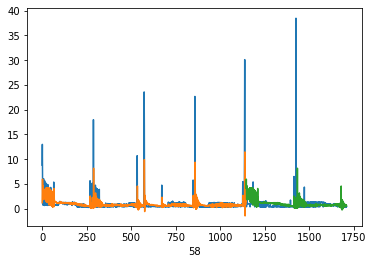

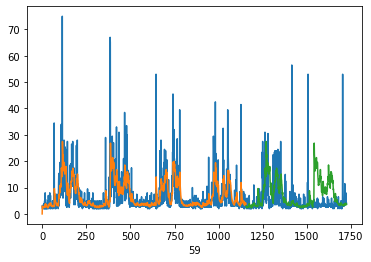

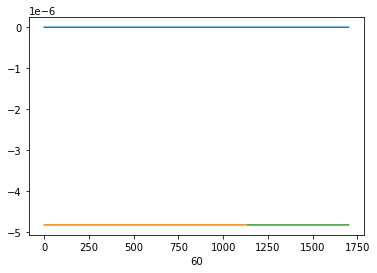

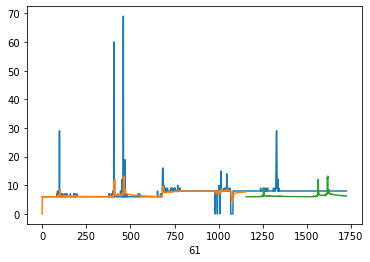

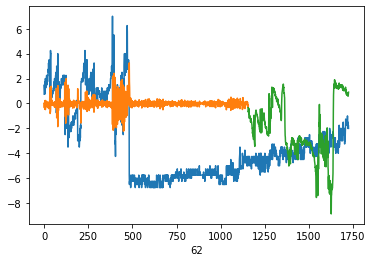

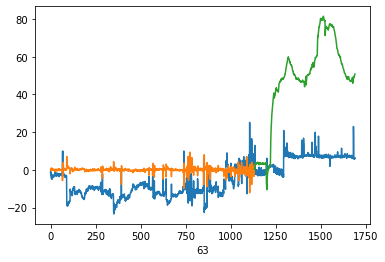

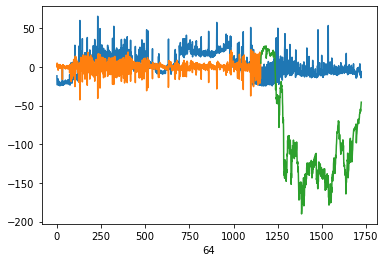

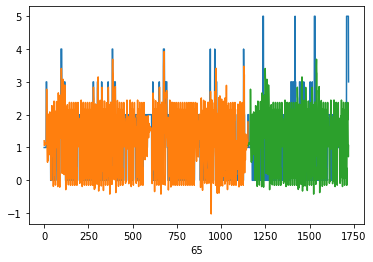

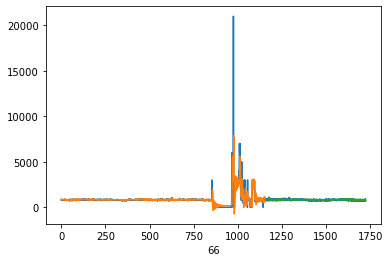

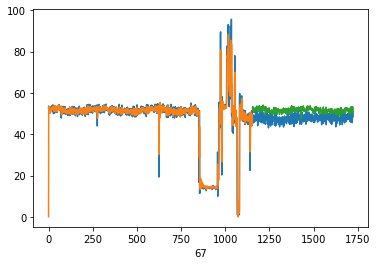

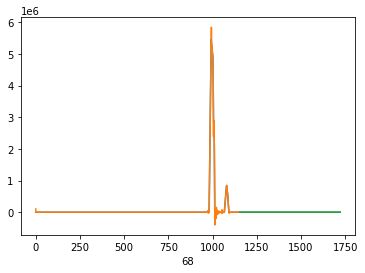

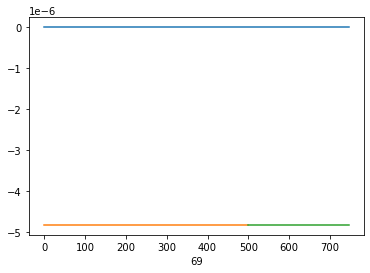

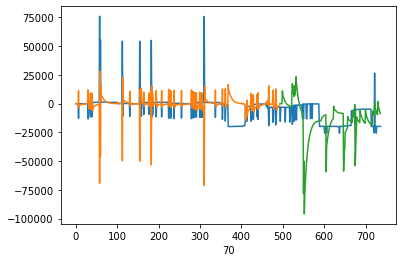

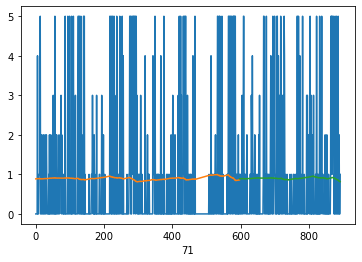

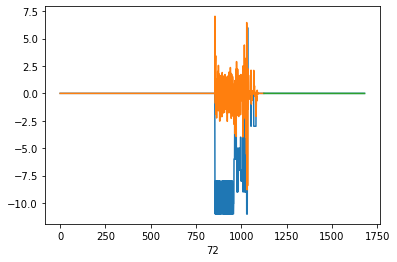

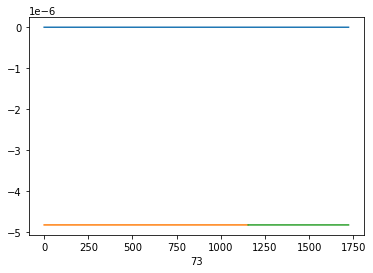

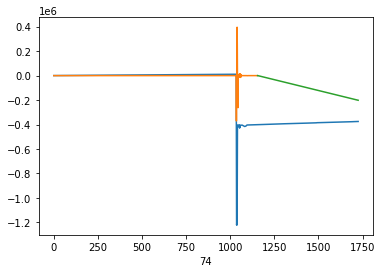

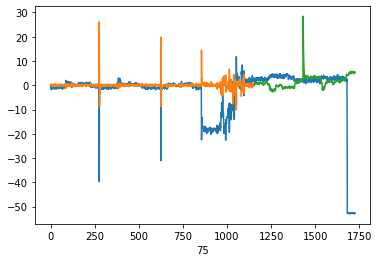

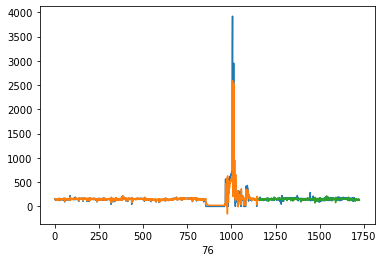

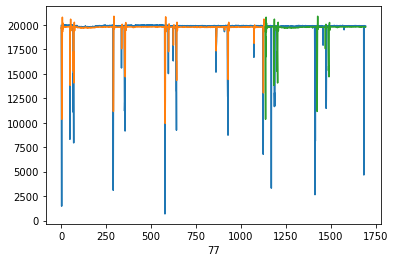

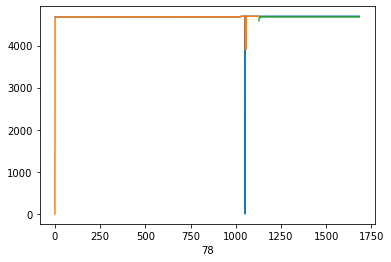

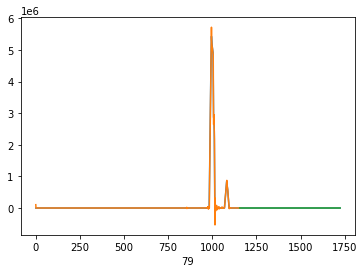

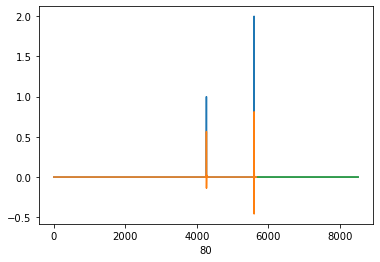

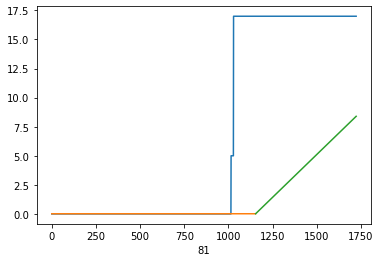

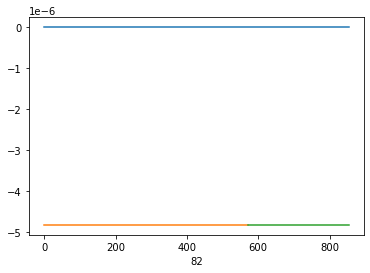

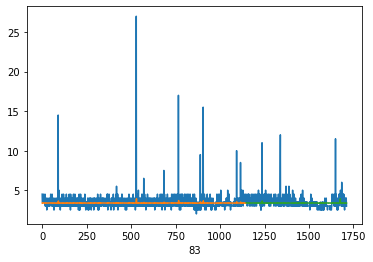

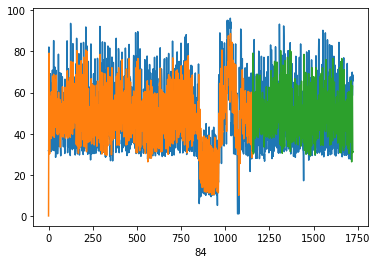

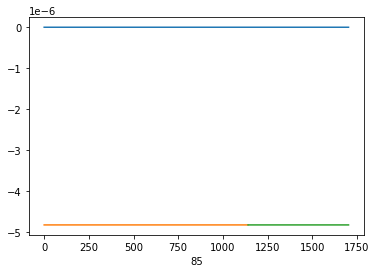

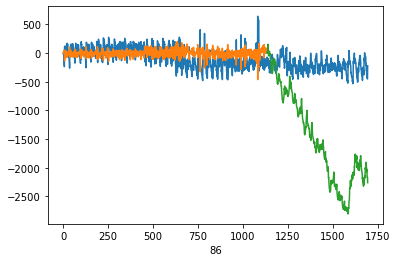

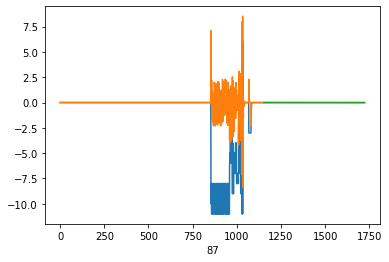

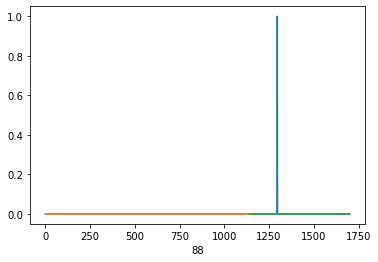

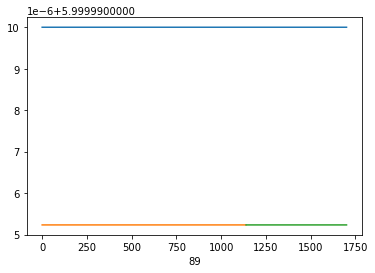

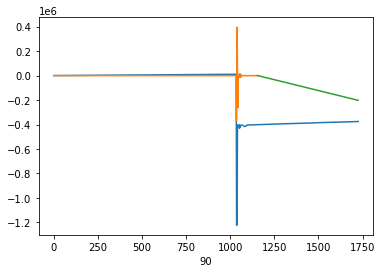

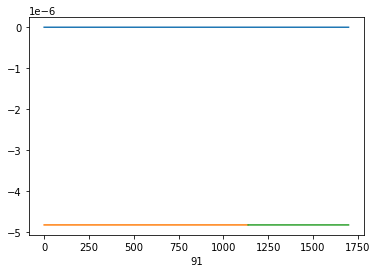

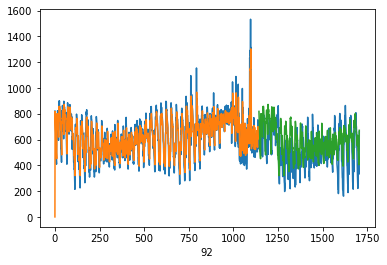

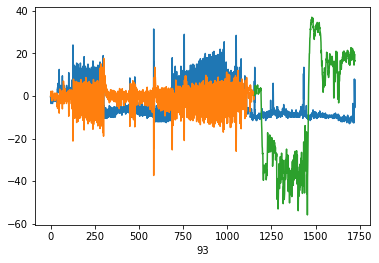

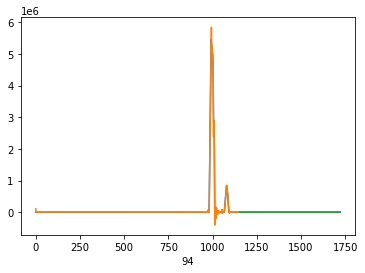

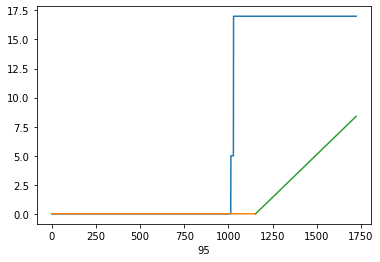

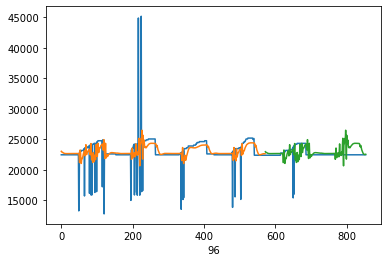

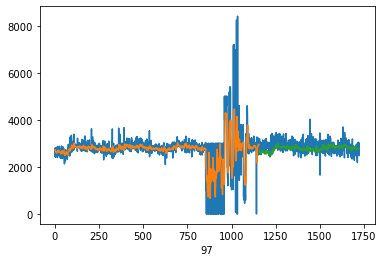

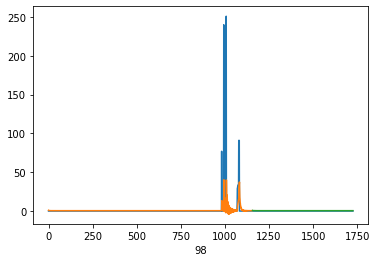

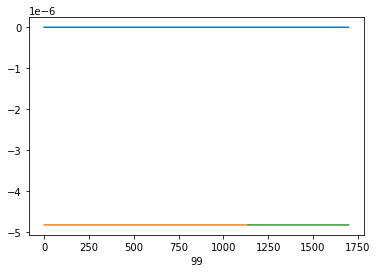

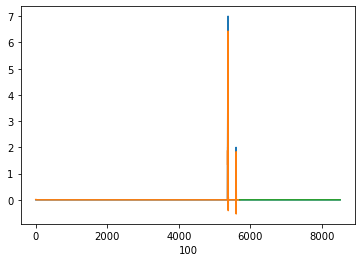

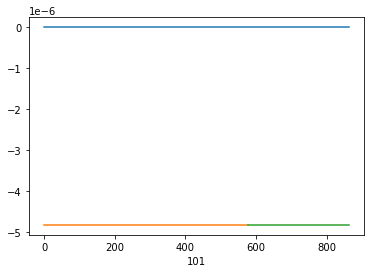

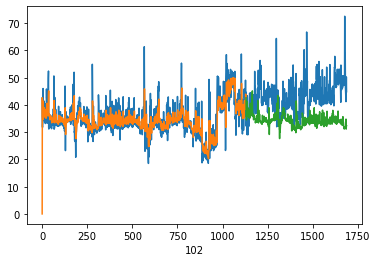

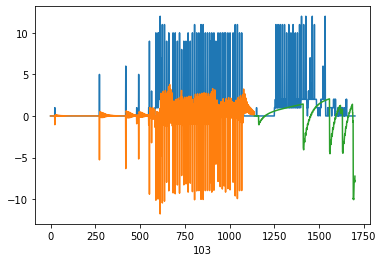

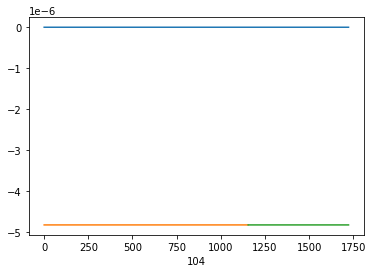

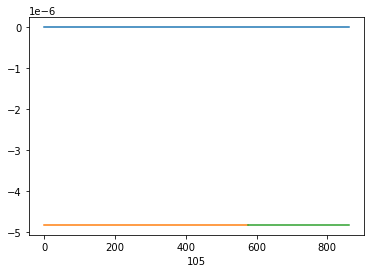

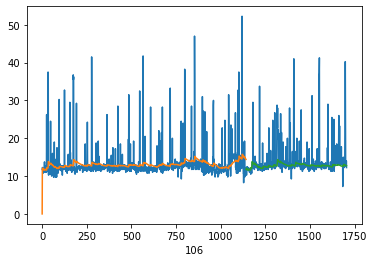

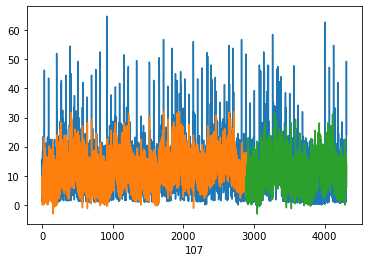

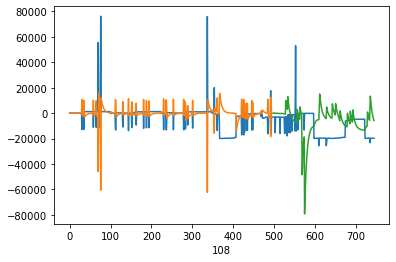

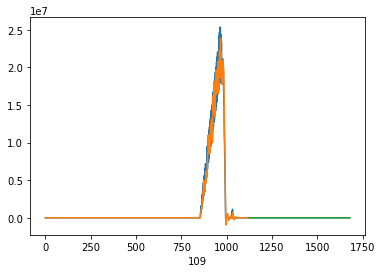

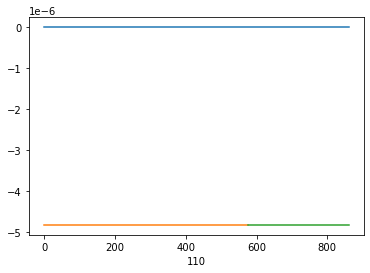

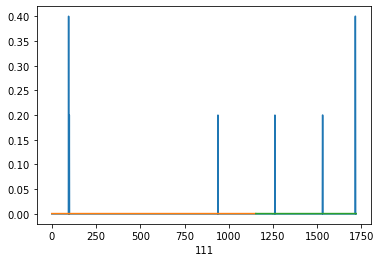

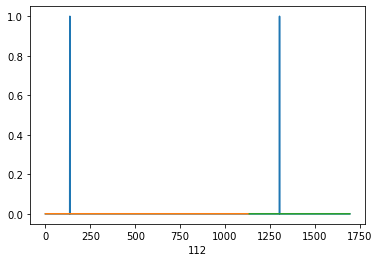

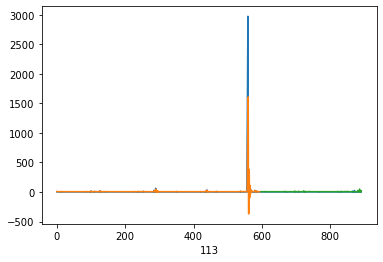

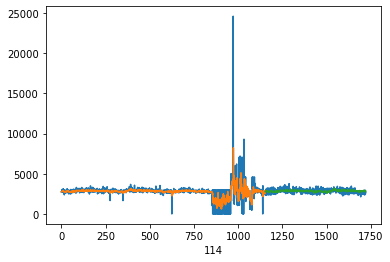

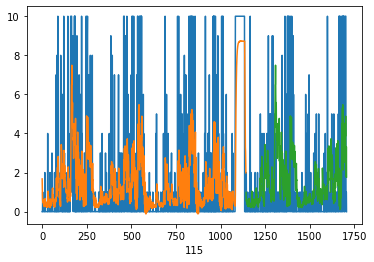

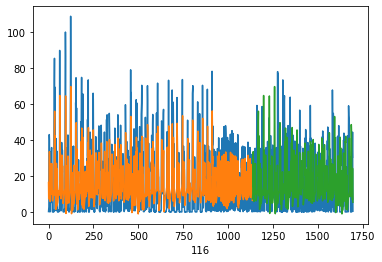

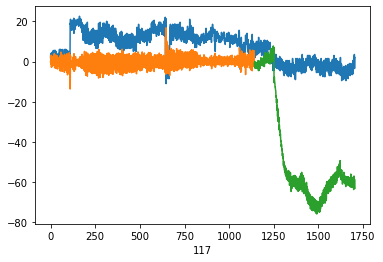

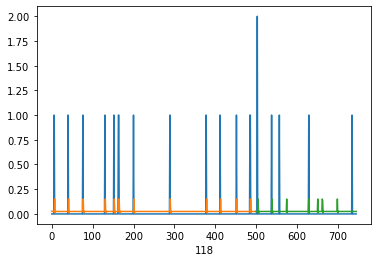

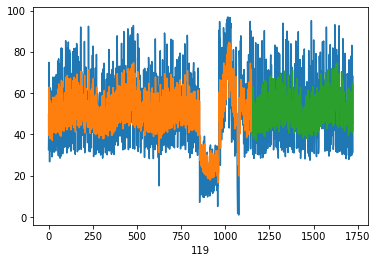

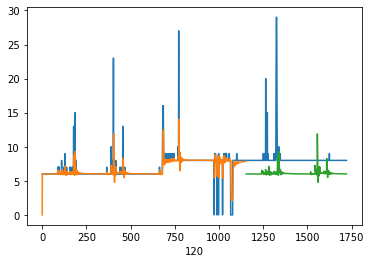

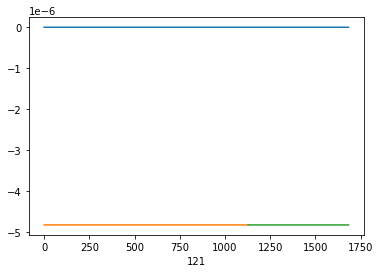

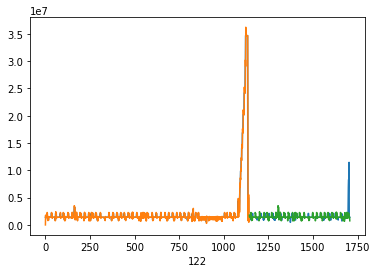

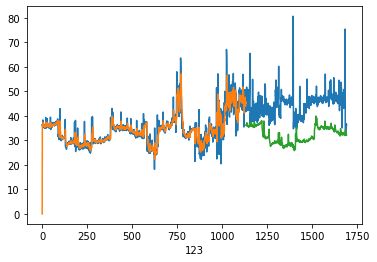

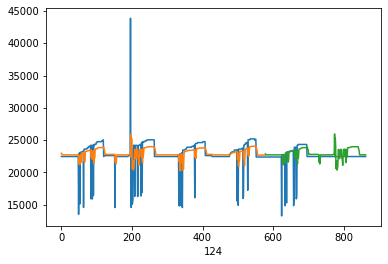

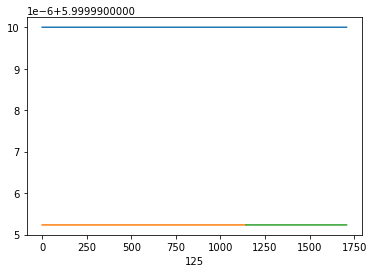

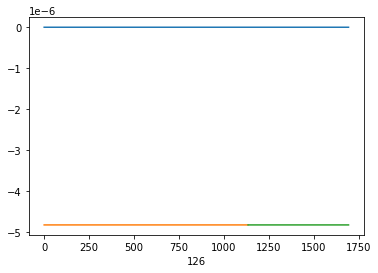

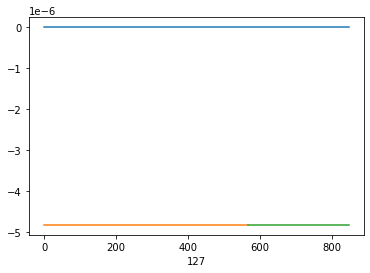

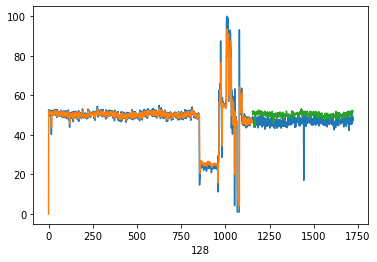

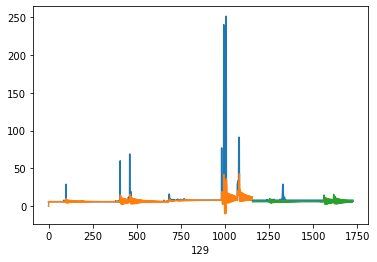

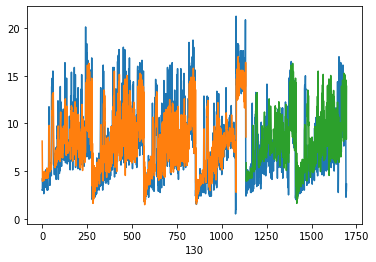

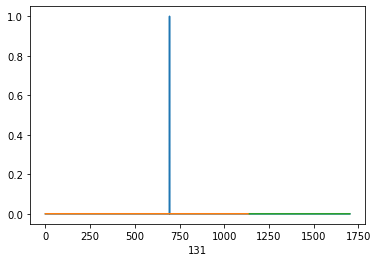

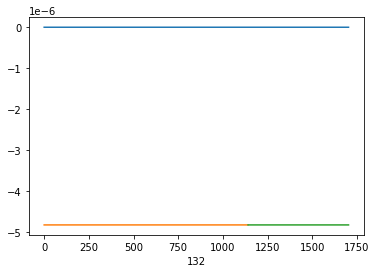

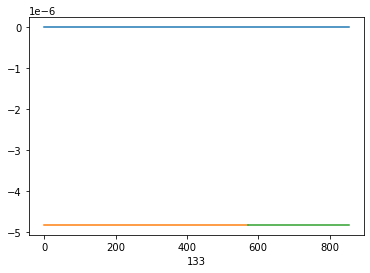

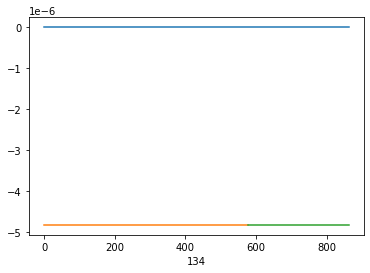

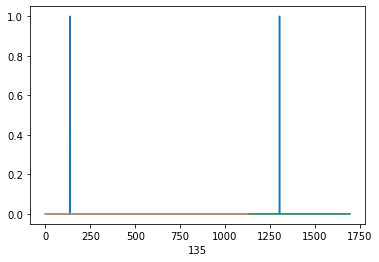

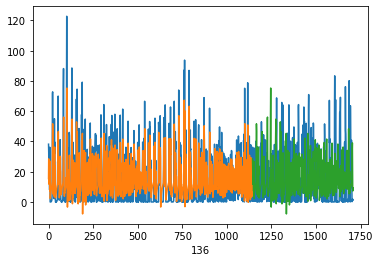

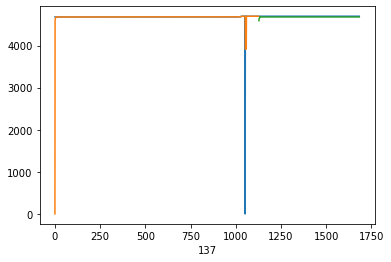

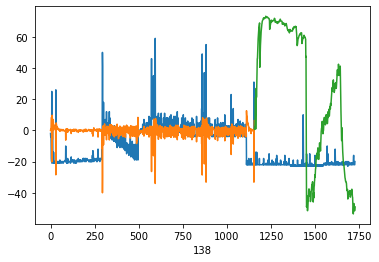

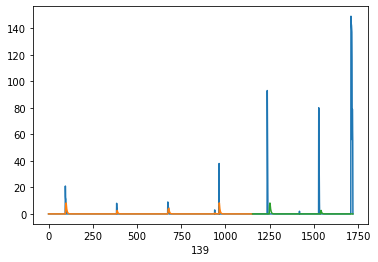

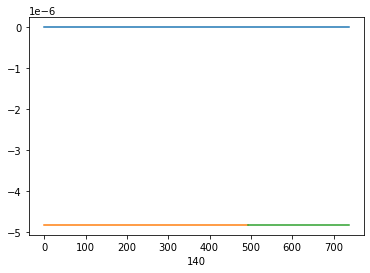

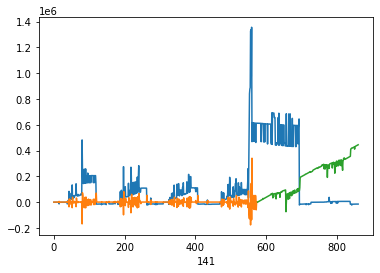

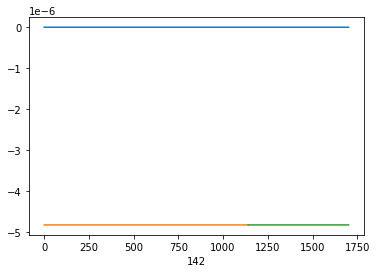

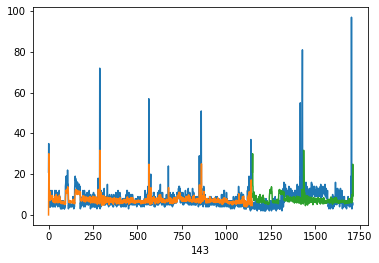

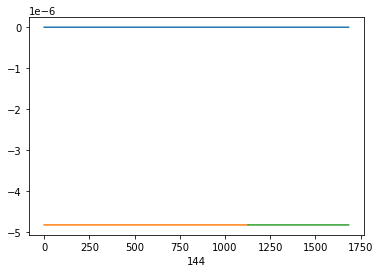

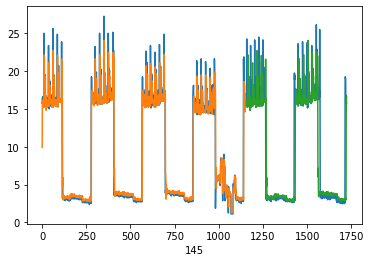

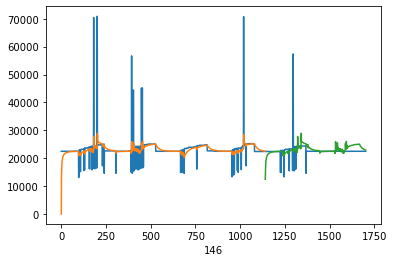

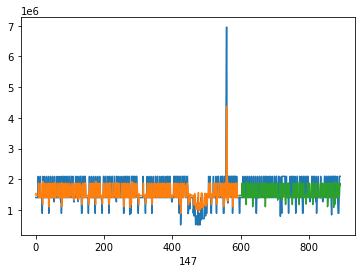

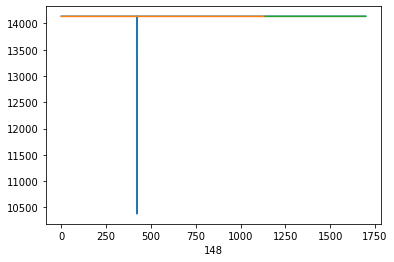

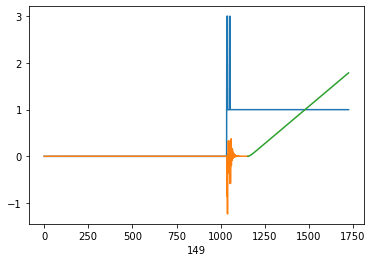

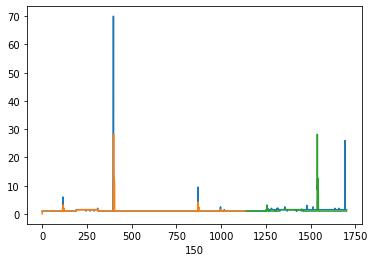

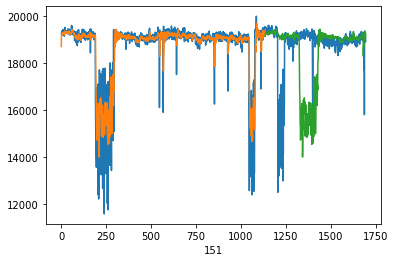

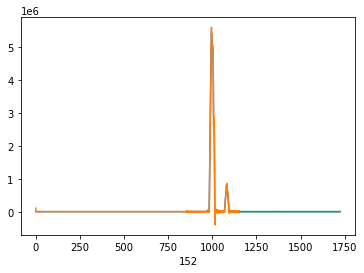

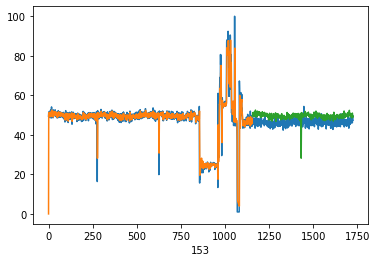

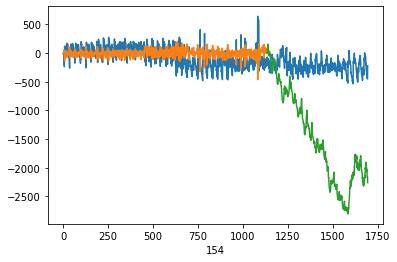

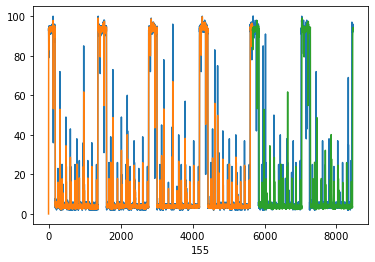

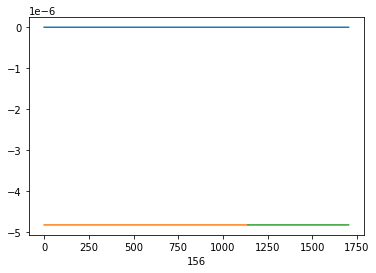

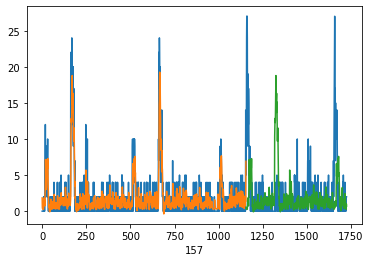

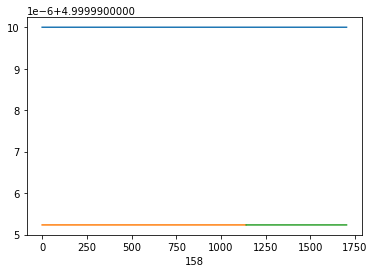

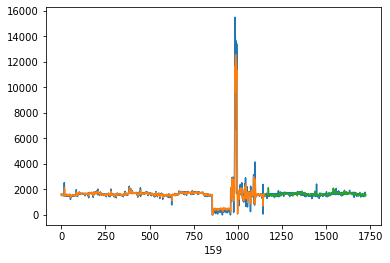

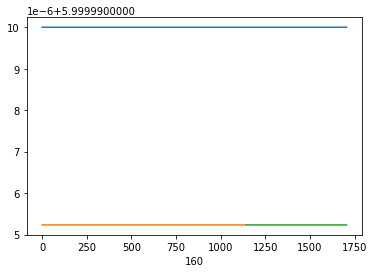

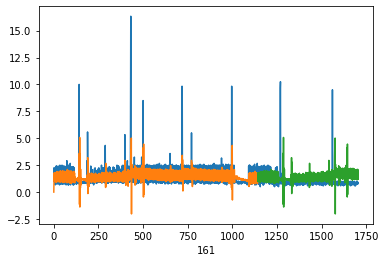

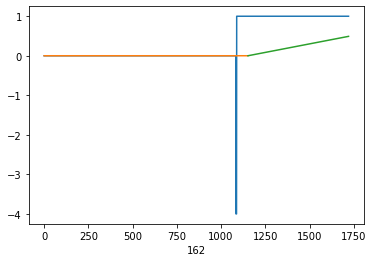

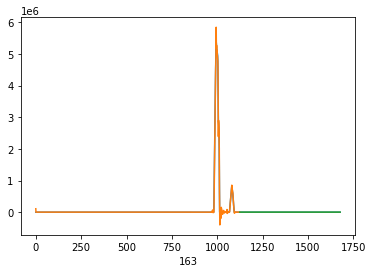

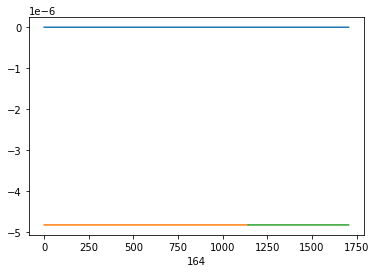

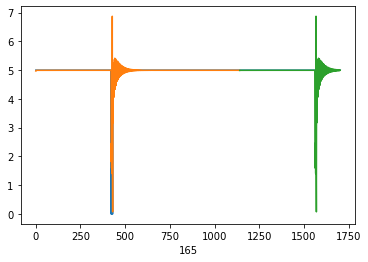

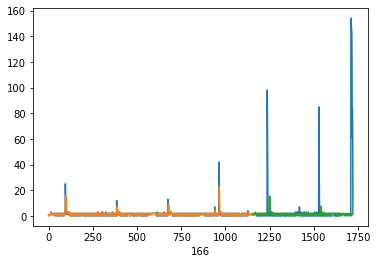

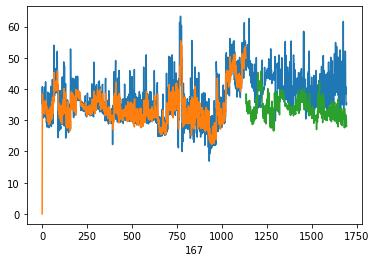

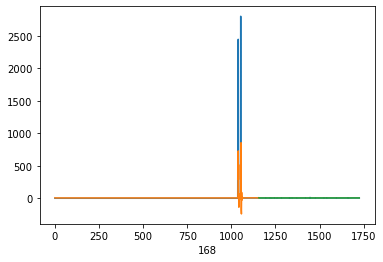

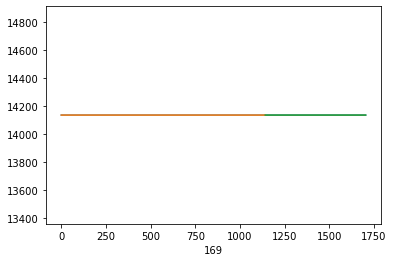

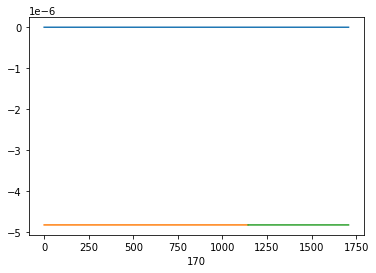

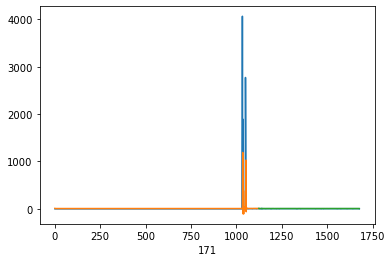

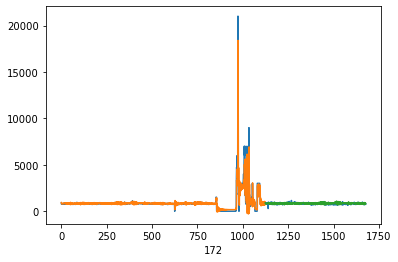

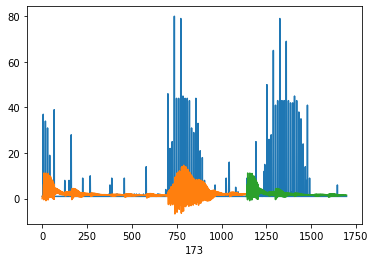

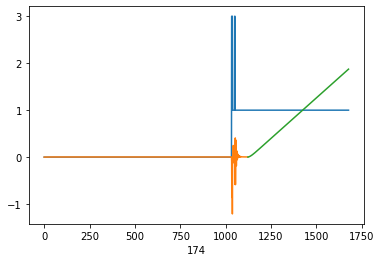

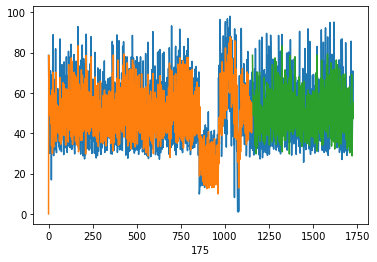

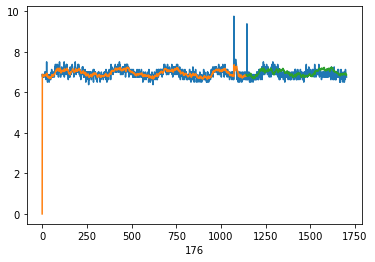

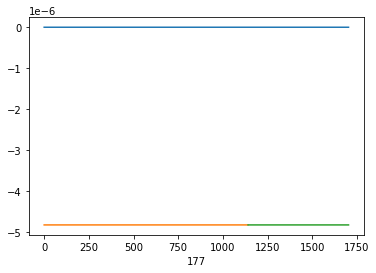

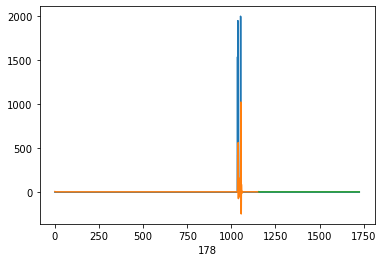

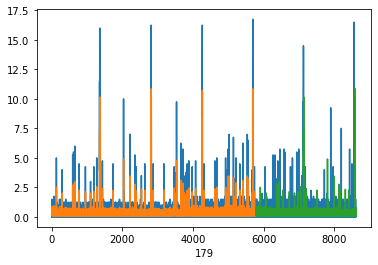

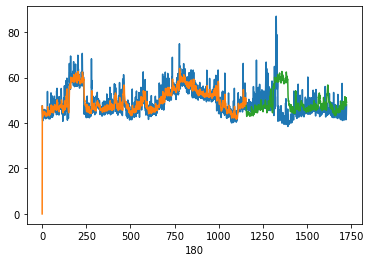

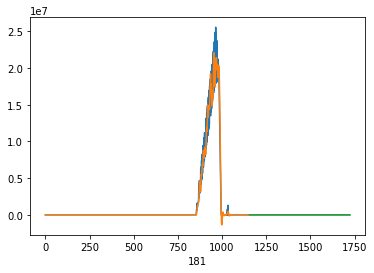

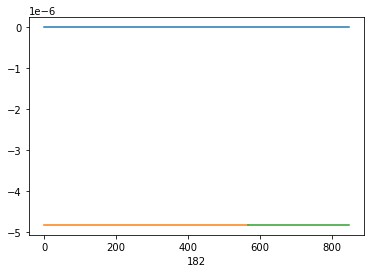

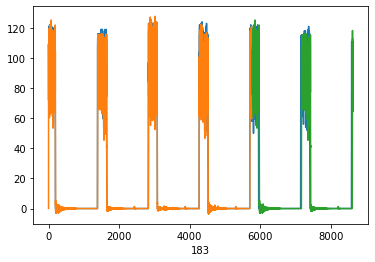

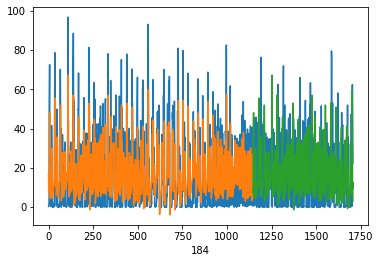

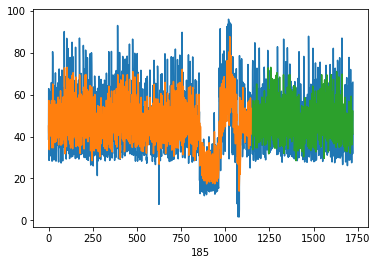

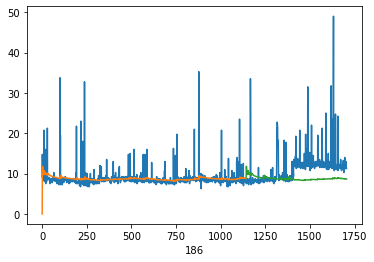

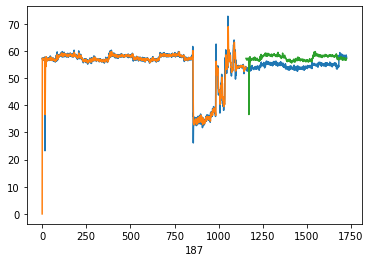

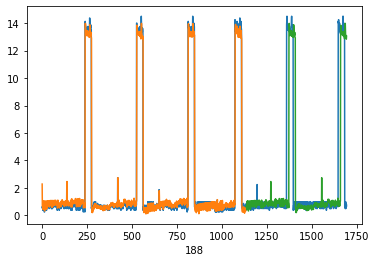

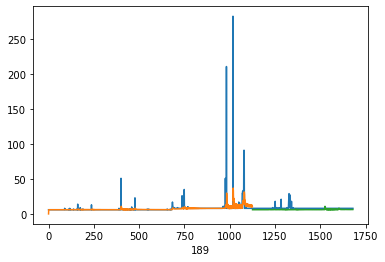

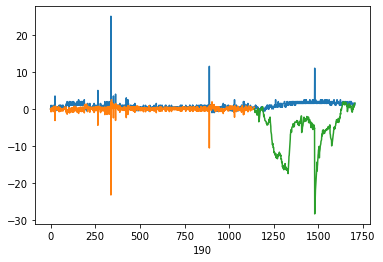

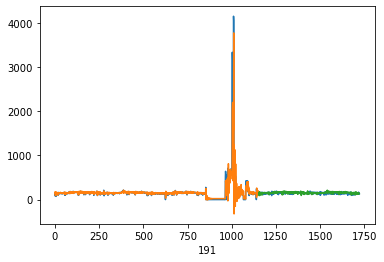

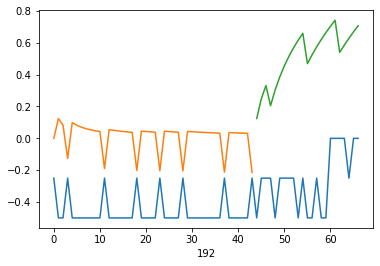

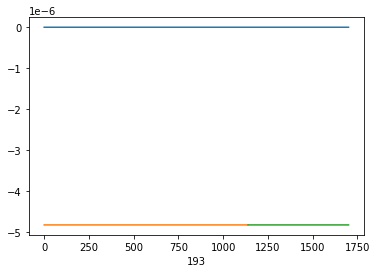

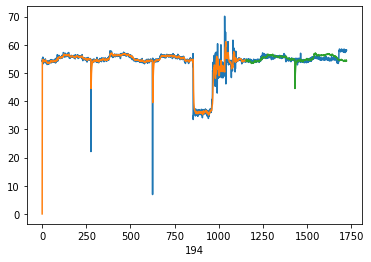

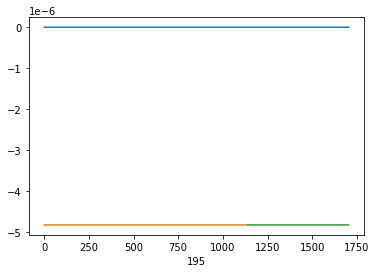

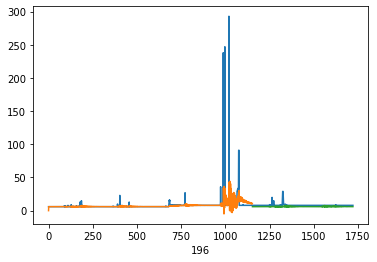

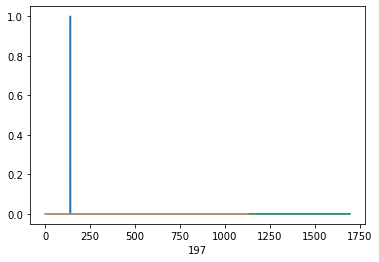

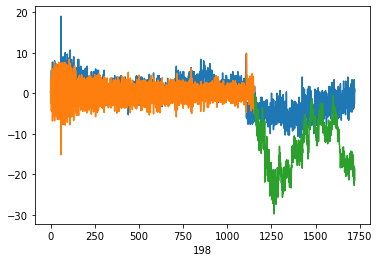

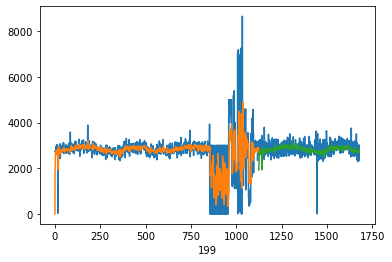

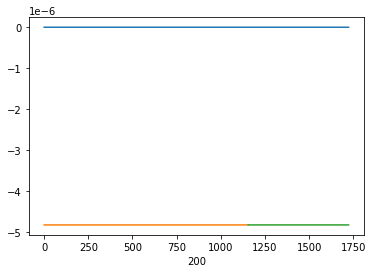

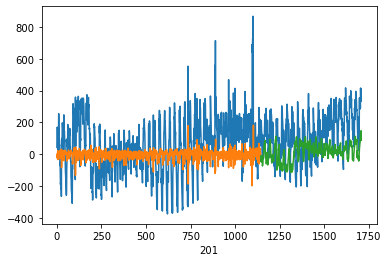

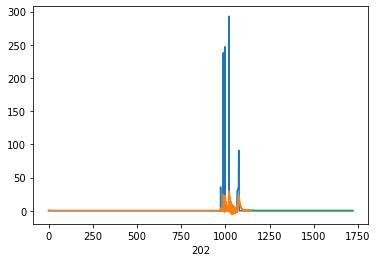

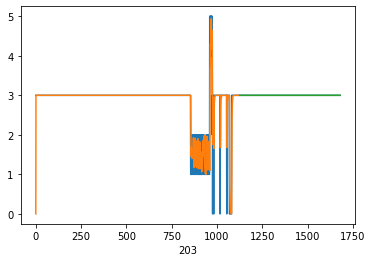

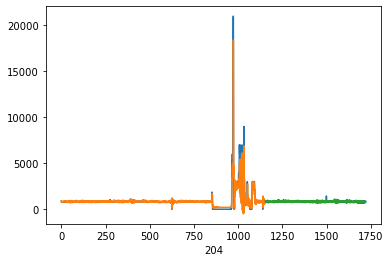

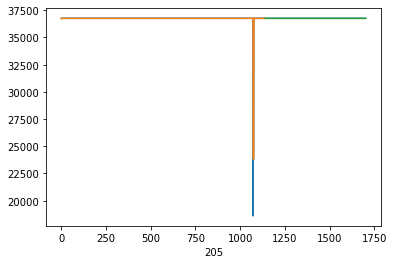

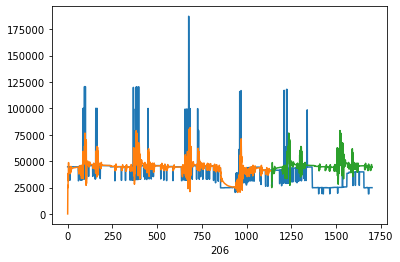

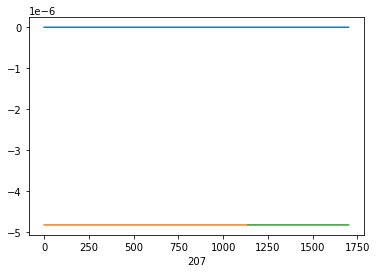

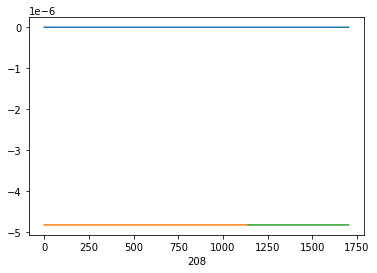

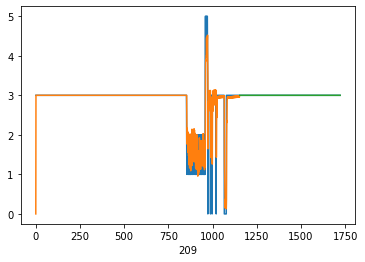

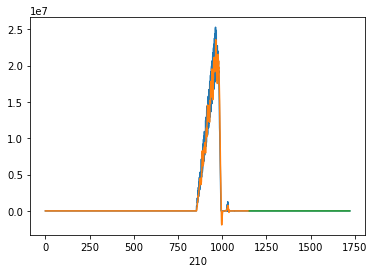

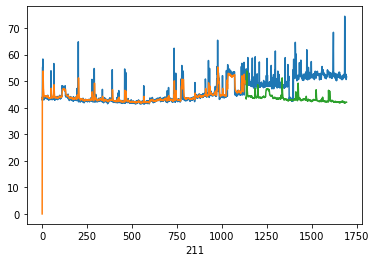

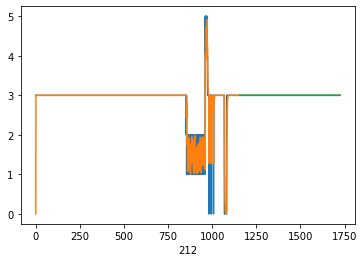

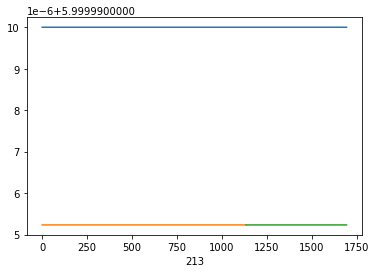

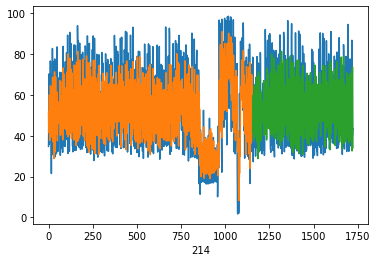

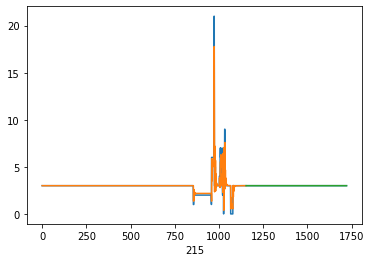

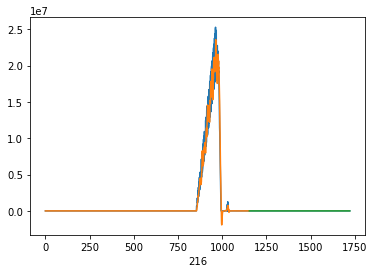

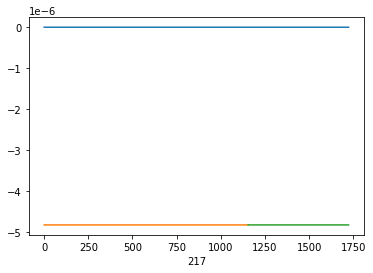

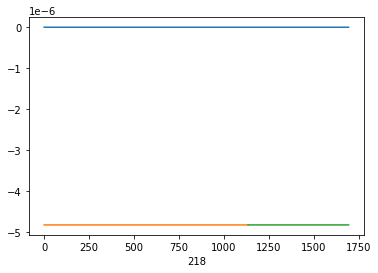

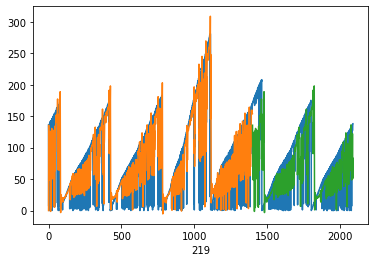

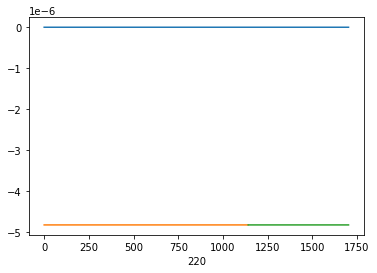

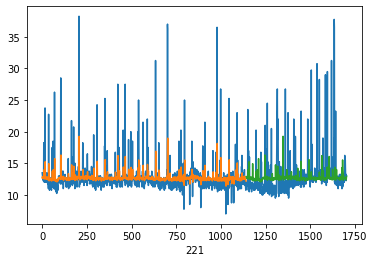

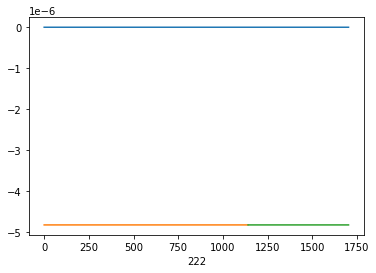

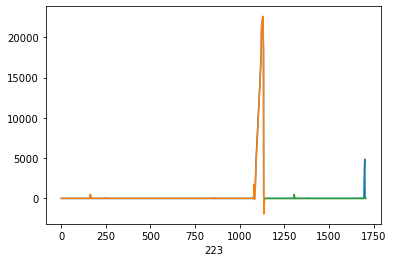

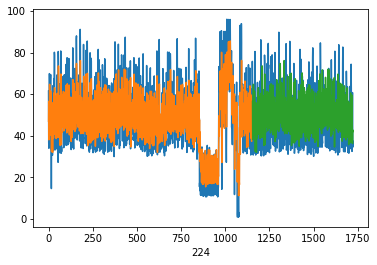

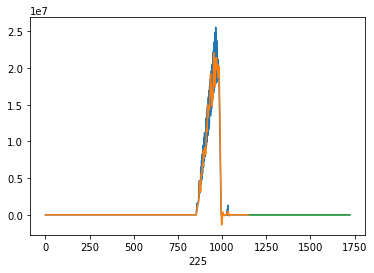

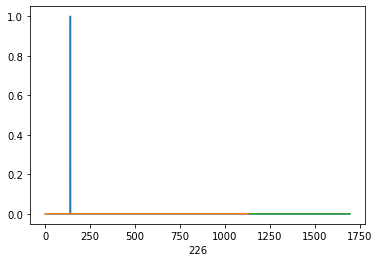

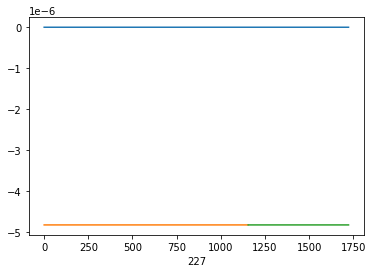

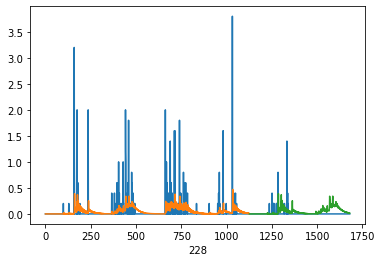

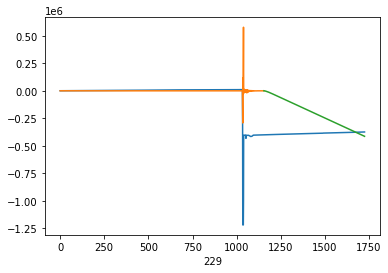

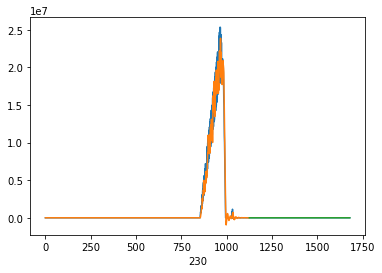

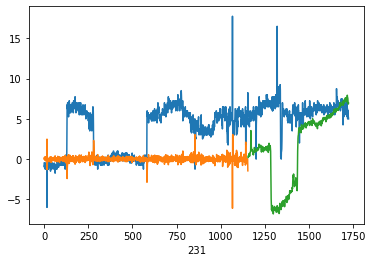

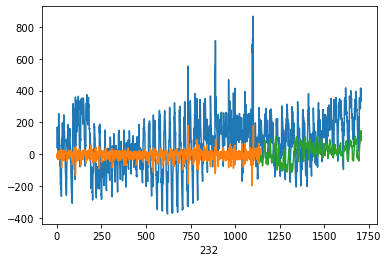

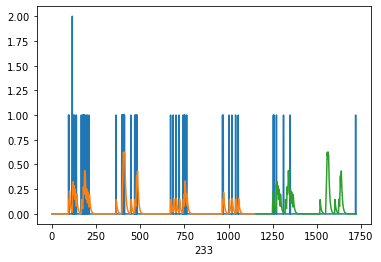

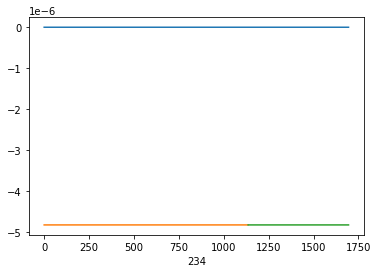

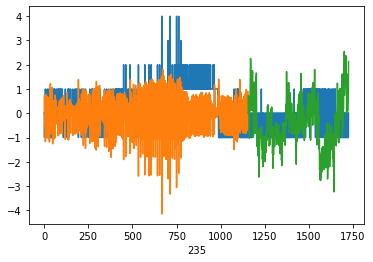

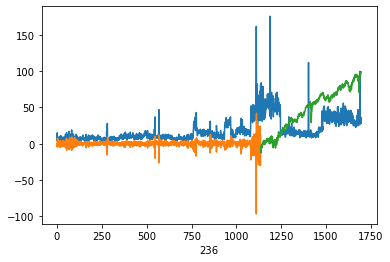

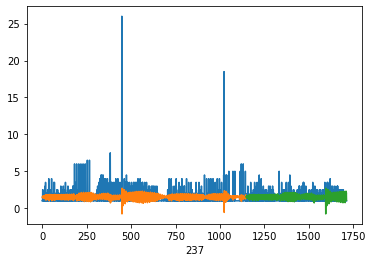

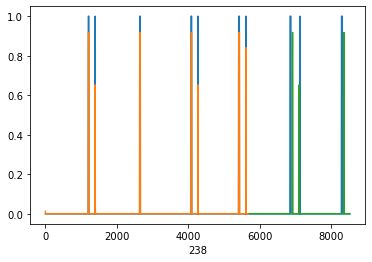

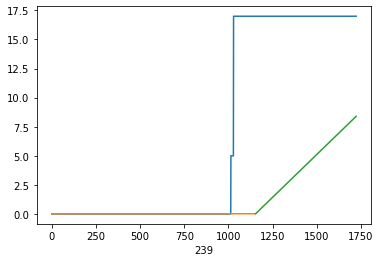

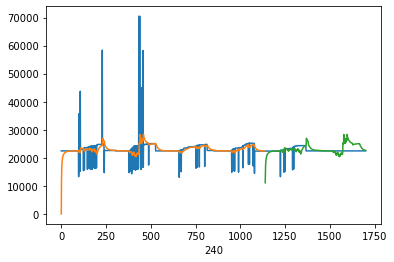

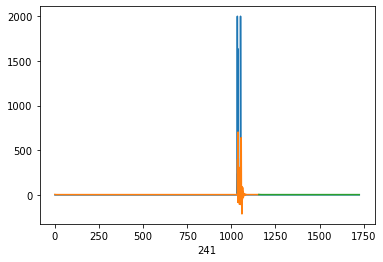

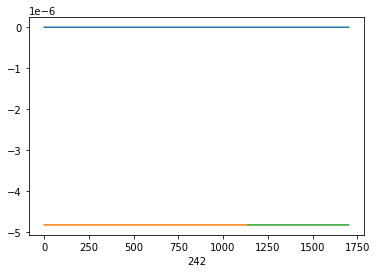

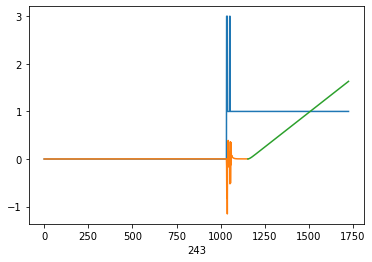

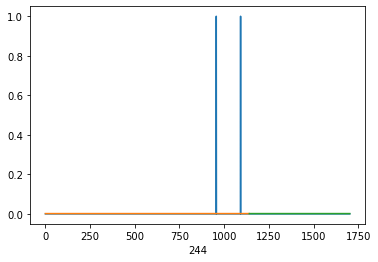

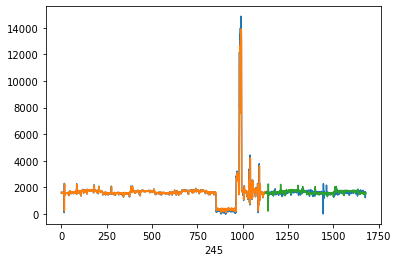

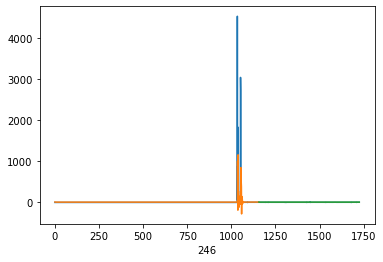

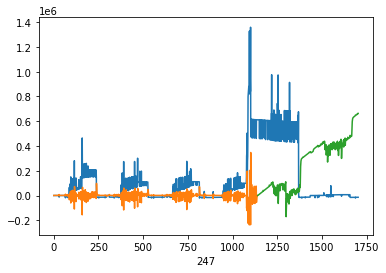

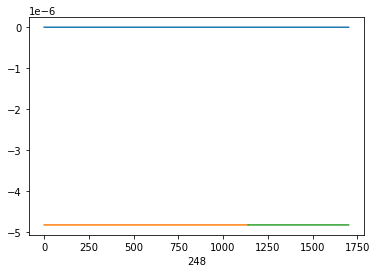

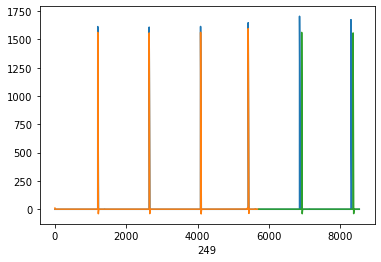

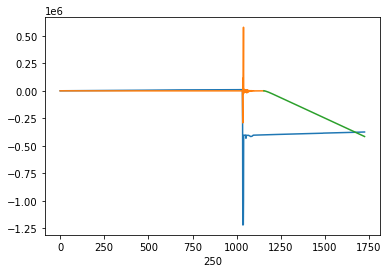

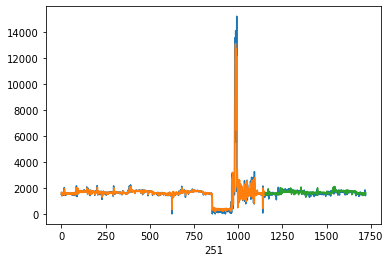

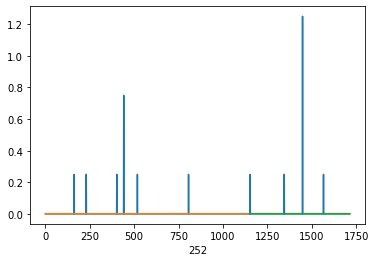

In [7]:
for i in range(sample):
    indx = keys_id[i]
    fig, ax = plt.subplots()
    # shift train predictions for plotting
    trainPlot = np.empty_like(dic_id[indx][1].reshape(-1,1))
    trainPlot[:, :] = np.nan
    if dic_id[indx][5] > 0.05:
        trainPlot[0:len(dic_id[indx][3][0])-1, :] = dic_id[indx][4].reshape(-1,1)
    else:
        trainPlot[0:len(dic_id[indx][3][0]), :] = dic_id[indx][4].reshape(-1,1)
    # shift test predictions for plotting
    validPlot = np.empty_like(dic_id[indx][1].reshape(-1,1))
    validPlot[:, :] = np.nan
    if dic_id[indx][5] > 0.05:
        validPlot[len(dic_id[indx][3][0])-1:len(dic_id[indx][1]), :] = np.array(dic_id[indx][3][2]).reshape(-1,1)
    else:
        validPlot[len(dic_id[indx][3][0]):len(dic_id[indx][1]), :] = np.array(dic_id[indx][3][2]).reshape(-1,1)
    # plot baseline and predictions
    ax.set_xlabel(str(i))
    ax.plot(dic_id[indx][1].reshape(-1,1))
    ax.plot(trainPlot)
    ax.plot(validPlot)
plt.show()